# Exercício 3 - Análise de sentimento no Twitter

Nesse exercício vamos analisar uma base de dados do Twitter. Vamos também aplicar um classificador deep learning em nossa base e comparar com um classificador mais básico.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU

Usaremos a base de dados Sentiment140, com sentimentos de tweets organizada pela Universidade de Stanford. Informações sobre a base podem ser encontradas no link (http://help.sentiment140.com/for-students). O formato da base no link é diferente do formato que usaremos nesse exercício, mas os dados são os mesmos. Assim, utilize a base de dados do Blackboard ou do Google Drive. É recomendado que o exercício seja executado no Google Colab, utilizando GPU ou TPU para o kernel, já que usaremos o Keras. 

É necessário descompactar o arquivo. Caso esteja executando no Google Colab, execute o procedimento de montagem do drive no Colab e descompacte o arquivo.

Vamos carregar a base de treinamento. Lembre-se de informar o caminho do arquivo no comando abaixo. Aqui consideramos que o arquivo de treinamento está disponível na pasta data.

In [7]:
cols = ['sentiment','id','date','query_string','user','text']
training_df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None, names=cols, encoding = "ISO-8859-1")

Vamos definir alguns parâmetros importantes. Primeiro definimos a quantidade de itens que vamos utilizar da base. A base possui 160000 registros, o que é pesado para analisarmos com deep learning. Definimos também a quantidade máxima de palavras que consideraremos na tokenização. O processo de tokenização que usaremos cria um dicionário de palavras e retorna um vetor com o índice de calada palavra no dicionário. Como estamos lidando com redes sociais, temos diversas palavras únicas, o que criaria um dicionário muito grande, por isso limitamos esse dicionário. Por fim, definimos o tamanho máximo de cada sentença, a fim de limitar o tamanho de cada vetor.

In [8]:
data_limit = 200000
max_words = 100000
max_len = 200

Vamos tratar nossos dados, removendo html e caracteres estranhos. Para isso criamos uma função que trata cada tweet em separado. Depois aplicamos essa função em cada tweet, já limitando ao nosso limite definido acima. Vamos aproveitar e embaralhar os dados, já que as classes estão ordenadas no dataset. 

In [9]:
training_df.drop(['id','date','query_string','user'],axis=1,inplace=True)
train_df = training_df.sample(frac=1).reset_index(drop=True)

In [10]:
import re
import lxml
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    return lower_case

In [11]:
clean_training_texts = []
for i in range(0, data_limit):
    if( (i+1)%100000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, data_limit ))
    clean_training_texts.append(tweet_cleaner(train_df['text'][i]))

Tweets 100000 of 200000 has been processed
Tweets 200000 of 200000 has been processed


Vamos tokenizar os tweets utilizando o Tokenizador do Keras. Esse tokenizador tem a vantagem de retornar sequências de números ao invés da sentença tokenizada. Essa sequência possuí índices das palavras em um dicionário com todas as palavras na lista. Isso é importante para que nossa rede possa treinar embeddings para as palavras. Aqui limitamos a quantidade de palavras no dicionário pelo parâmetro max_words

In [12]:
tokenizer = Tokenizer(num_words=max_words,lower=True, split=" ")
tokenizer.fit_on_texts(clean_training_texts)
tokens = tokenizer.texts_to_sequences(clean_training_texts)

Vamos limitar nossas sequências para um número definido de valores, adicionando zeros caso a sequência seja menor ou cortando a sequência caso seja maior

In [13]:
X = sequence.pad_sequences(tokens, maxlen=max_len)

Vamor gerar nosso conjunto de labels (y). Para isso, retiramos do dataframe inicial os registros da coluna sentiment limitando ao parâmetro data_limit. Fazemos um tratamento no conjunto para que esse seja binário. No dataset original, o rótulo 0 indica negativo e o rótulo 4 indica positivo.

In [14]:
y = train_df.sentiment[:data_limit]
y = np.array([1 if v == 4 else 0 for v in y])

Agora vamos criar nossa rede de classificação. Para isso, crie uma rede recorrente que classifique nossos tweets. A rede deve obrigatoriamente ter uma camada de embedding, uma camada recorrente (SimpleRNN, GRU ou LSTM) e a camada de saída da classificação (camada densa com 1 unidade, de preferência com ativação sigmoide). Você está livre para criar quantas camadas desejar, lembrando que quanto mais camadas, mais demorado é o treinamento da rede.

In [15]:
model = Sequential()

model.add(Embedding(data_limit, 128, input_length=max_len, trainable=True))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          25600000  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 25,633,025
Trainable params: 25,633,025
Non-trainable params: 0
_________________________________________________________________


Vamos treinar nossa rede. Aqui está definido alguns parâmetros para treinamento, sinta-se a vontade para alterar esses parâmetros conforme desejar

In [18]:
history = model.fit(X, y, epochs=10, batch_size=128, validation_split=0.25)

Epoch 1/10
1172/1172 [==============================] - 220s 187ms/step - loss: 0.5322 - acc: 0.7320 - val_loss: 0.5013 - val_acc: 0.7629
Epoch 2/10
1172/1172 [==============================] - 220s 188ms/step - loss: 0.4517 - acc: 0.7931 - val_loss: 0.4692 - val_acc: 0.7836
Epoch 3/10
1172/1172 [==============================] - 229s 195ms/step - loss: 0.4200 - acc: 0.8101 - val_loss: 0.4704 - val_acc: 0.7833
Epoch 4/10
1172/1172 [==============================] - 224s 191ms/step - loss: 0.3933 - acc: 0.8256 - val_loss: 0.4771 - val_acc: 0.7815
Epoch 5/10
1172/1172 [==============================] - 225s 192ms/step - loss: 0.3673 - acc: 0.8396 - val_loss: 0.5006 - val_acc: 0.7699
Epoch 6/10
1172/1172 [==============================] - 227s 194ms/step - loss: 0.3449 - acc: 0.8513 - val_loss: 0.4944 - val_acc: 0.7704
Epoch 7/10
1172/1172 [==============================] - 227s 193ms/step - loss: 0.3200 - acc: 0.8642 - val_loss: 0.5155 - val_acc: 0.7766
Epoch 8/10
1172/1172 [============

Verifique a perda e a acurácia de validação durante o treinamento. Verifique se seu modelo está performando bem com os parâmetros e arquitetura de rede escolhida. Caso deseje, utilize o history para mostrar gráficos com os dados do treinamento.

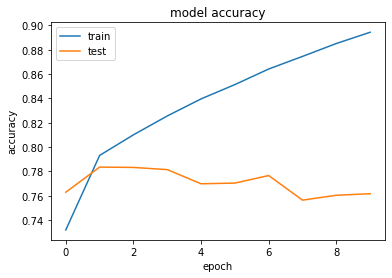

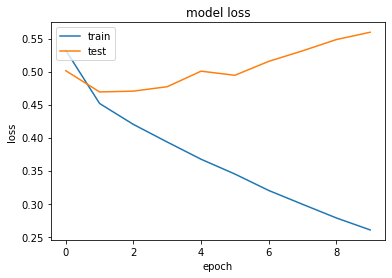

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Vamos comparar com um classificador clássico, a Regressão Logística. Primeiramente vamos vetorizar o texto usando o TF-IDF. 

In [24]:
#complete as linhas com o TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(clean_training_texts)

Separe em conjunto de teste e validação, usando o train_test_split. Aqui vamos manter a mesma taxa de validação (test_size) usada ao treinar a rede recorrente.

In [25]:
#complete a linha abaixo
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)

Crie a regressão logistica e treine o modelo.

In [26]:
#complete as linhas abaixo
lr = LogisticRegression(max_iter=1000)
#complete a linha abaixo para treinar o modelo
lr.fit(X_train, y_train)
print ("Accuracy : %s" % (np.round(accuracy_score(y_val, lr.predict(X_val)),4)))

Accuracy : 0.786


Vamos agora ver a acurácia do modelo. A acurácia é muito diferente do modelo deep learning?

In [27]:
print ("Accuracy : %s" % (accuracy_score(y_val, lr.predict(X_val))))

Accuracy : 0.785975
